In [8]:
import torch
import sys
sys.path.append('..')
sys.path.append('../..')
from utils import *
from model import *
from data import *
import numpy as np
import matplotlib.pyplot as plt


working_dir = f'/home/zhiqin/data/LLM/LLM_pami/LLM_init_exact/refine_adam_epoch_207_data_90w_warmup_normal_init_34_wrong_43_unseen_diff_ini/GPT_normal_init_diff_lr_1e-5_composition_task_34_unseen_43_unseen_diff_ini_0.5_test_eps_1e-08_wd_0.01_beta2_0.999/composition-N_900000-2L1H_seed1'
state_dict=torch.load(f'{working_dir}/model/model_60.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = load_args(f'{working_dir}/config.json')

model = myGPT_specific_test_for_resnet_no_mask(args, device)
model.load_state_dict(state_dict)
model.to(device)

weight=model.decoder.layers[0].dec_self_attn.W_Q.weight.detach().cpu().numpy()

from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix_emd = cosine_similarity(weight)


order = []
size = similarity_matrix_emd.shape[0]
order1 = range(size)
k = 0
order_temp = []
order1 = []
prune_index=[]
for j in range(size):
    if j != 0:
        for i in order2:
            if similarity_matrix_emd[k][i] > 0.4:
                order.append(i)
            else:
                order1.append(i)
    else:
        for i in range(size):
            if similarity_matrix_emd[0][i] > 0.4:
                order.append(i)
            else:
                order1.append(i)
                

    order_temp = order_temp + order

    if len(order_temp) == size:
        break
    k = order1[0]
    order2 = order1
    order1 = []
    order = []

similarity_matrix_emd = similarity_matrix_emd[order_temp,:]
similarity_matrix_emd = similarity_matrix_emd[:,order_temp]

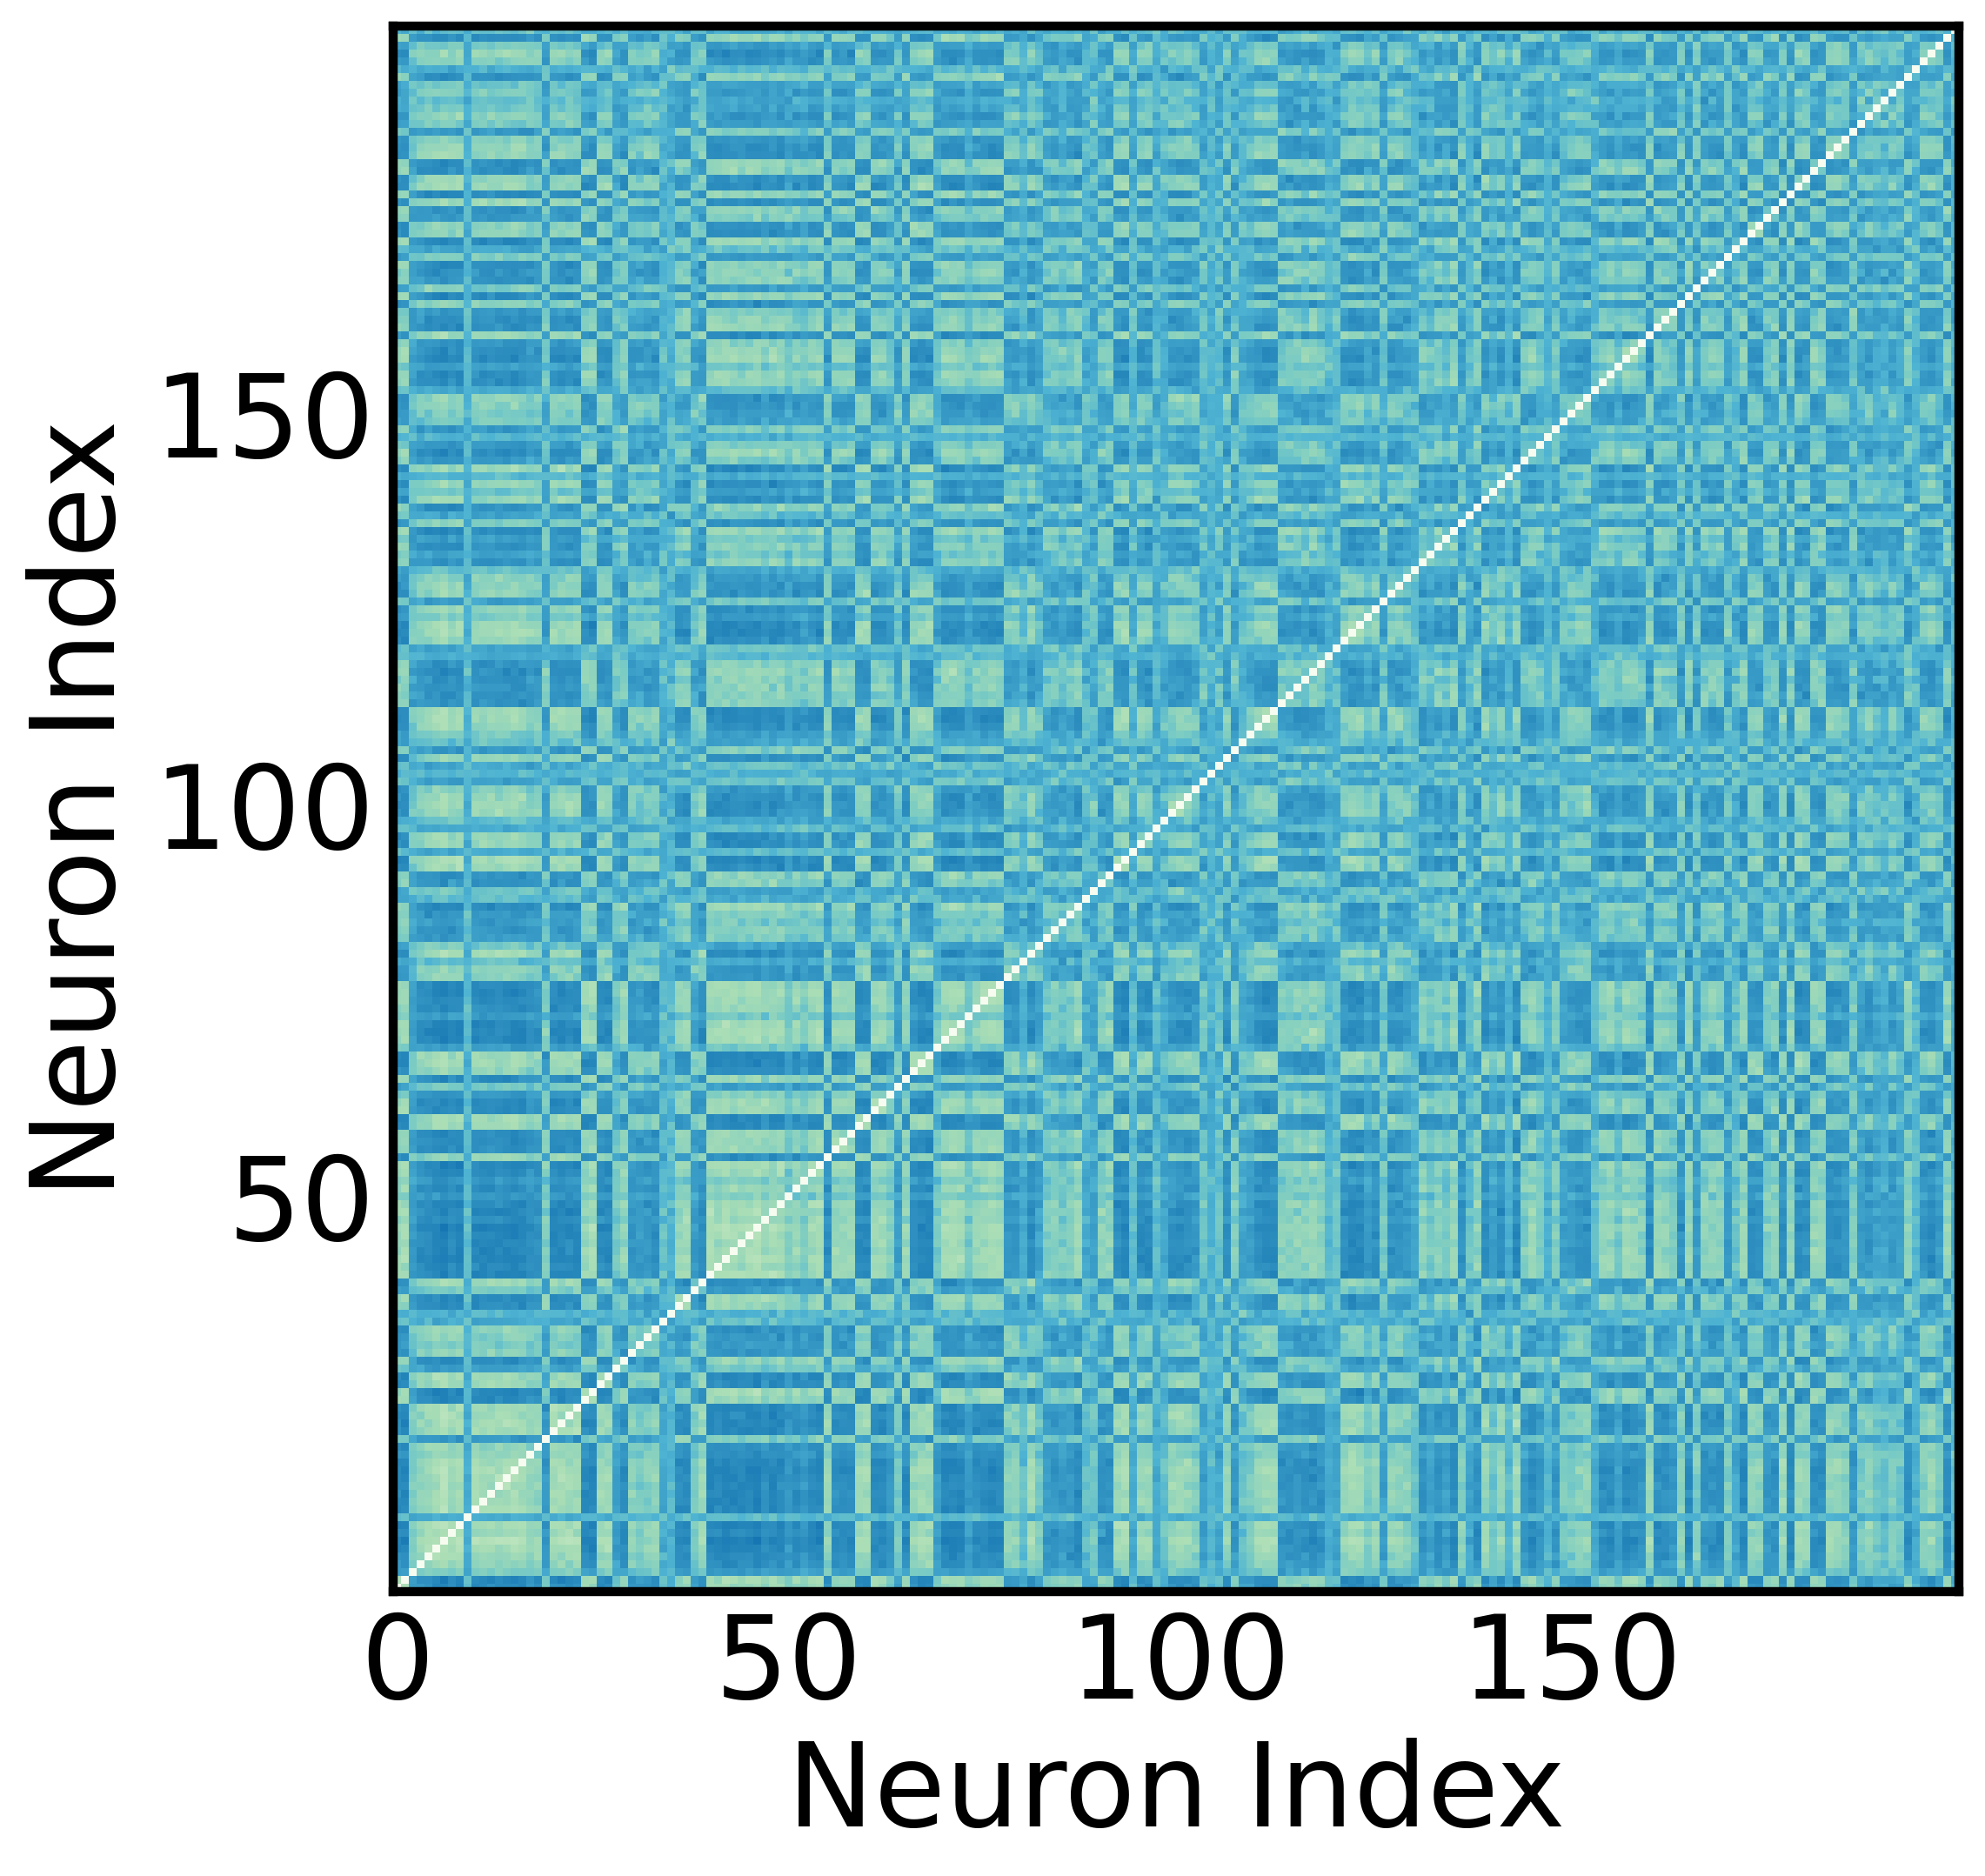

In [9]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(8, 8), dpi=300)
format_settings(fs=32, lw=6, ms=12.5, axlw=2.5, major_tick_len=0, left=0.2, right=0.95, top=0.98, bottom=0.05)
middle_value=0.38

cmap = cm.GnBu_r
cmap1 = mcolors.ListedColormap(cmap(np.linspace(0.0, middle_value, 256)))
cmap2 = mcolors.ListedColormap(cmap(np.linspace(middle_value, 1.0, 256)))

colors1 = cmap(np.linspace(0.0, middle_value, 256))
colors2 = cmap(np.linspace(middle_value, 1.0, 256))


combined_colors = np.vstack((colors1, colors2))

combined_cmap = mcolors.ListedColormap(combined_colors)

plt.imshow(similarity_matrix_emd, cmap=combined_cmap, origin='lower',vmin=-1, vmax=1)
plt.xlabel('Neuron Index', fontsize=32)
plt.ylabel('Neuron Index', fontsize=32)

plt.yticks([50, 100, 150])
plt.xticks([0, 50, 100, 150])

plt.savefig('/home/zhiqin/LLM_from_4090/plot_fot_pami/pic/cossim_WQ_0.5.png')
